Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.5.2
IPython 7.3.0

torch 1.0.1.post2


- Runs on CPU or GPU (if available)

# Model Zoo -- Convolutional Conditional Variational Autoencoder 

## (with labels in reconstruction loss)

A simple convolutional conditional variational autoencoder that compresses 768-pixel MNIST images down to a 50-pixel latent vector representation.

This implementation concatenates the inputs with the class labels when computing the reconstruction loss as it is commonly done in non-convolutional conditional variational autoencoders. This leads to substantially poorer results compared to the implementation that does NOT concatenate the labels with the inputs to compute the reconstruction loss. For reference, see the implementation [./autoencoder-cnn-cvae_no-out-concat.ipynb](./autoencoder-cnn-cvae_no-out-concat.ipynb)

## Imports

In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 13456
learning_rate = 1e-4
num_epochs = 1000
batch_size = 256

# Architecture
num_classes = 2
num_features = 784
num_latent = 20



Device: cuda:0


In [4]:
# load dataset and cut it into train val part and shuffle them
data = np.loadtxt('sync_detection_data.txt')
label = np.loadtxt('sync_detection_label.txt')
N, D = np.shape(data)
label_int = np.zeros((N),dtype=int)
for k in range(N):
    label_int[k] = int(label[k])

ratio_train = 0.7
ind_cut = int(ratio_train * N)
ind = np.random.permutation(N)
train_data = data[ind[:ind_cut]]
train_datas = train_data[:256*40]
val_data = data[ind[ind_cut:]]

train_label = label[ind[:ind_cut]]
train_labels = train_label[:256*40]
val_label = label[ind[ind_cut:]]
np.shape(train_datas)

(10240, 784)

In [6]:
mean = np.mean(train_datas)
var = np.var(train_datas)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)
# preprocessing is so important
def data_in_one(inputdata):
    inputdata = (inputdata-inputdata.min())/(inputdata.max()-inputdata.min())
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

train_datas_process = data_in_one(train_data)
mean = np.mean(train_datas_process)
train_datas_process = train_datas_process
var = np.var(train_datas_process)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)

mean:
-4.070974715805149
sigma:
11.340051647575134
mean:
0.5097777235025349
sigma:
0.07382945753203313


## Model

In [7]:
##########################
### MODEL
##########################


def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1+self.num_classes,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [8]:
resume_flag = False
if (resume_flag==True):
    checkpoint = torch.load(dir_name)
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:    
    start_epoch = 0

start_time = time.time()

iters = int(256*40/batch_size)

for epoch in range(start_epoch,num_epochs):
    for batch_idx in range(iters):
        features = train_datas_process[batch_idx*batch_size:(batch_idx+1)*batch_size]
        targets = train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size]
        targets = np.transpose(targets)
        features = torch.from_numpy(features)
        targets = torch.from_numpy(targets)
        features = features.to(device,torch.float32)
        features = features.view(batch_size,-1,28,28)
        targets = targets.to(device,dtype=torch.int64)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        
        ### Add condition
        onehot_targets = to_onehot(targets, num_classes, device)
        onehot_targets = onehot_targets.view(-1, num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x_con = torch.cat((features, ones), dim=1)
        
        
        ### Compute loss
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        ### UPDATE MODEL PARAMETERS
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | kl_divergence: %.4f | pixelwise_bce: %.4f | Cost: %.4f'  
                   %(epoch+1, num_epochs, batch_idx, 
                     iters, kl_divergence, pixelwise_bce, cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/1000 | Batch 000/040 | Cost: 418338.7500
Epoch: 001/1000 | Batch 020/040 | Cost: 418540.0000
Time elapsed: 0.02 min
Epoch: 002/1000 | Batch 000/040 | Cost: 418106.1250
Epoch: 002/1000 | Batch 020/040 | Cost: 418033.2812
Time elapsed: 0.03 min
Epoch: 003/1000 | Batch 000/040 | Cost: 416386.0625
Epoch: 003/1000 | Batch 020/040 | Cost: 411040.5000
Time elapsed: 0.03 min
Epoch: 004/1000 | Batch 000/040 | Cost: 393010.0000
Epoch: 004/1000 | Batch 020/040 | Cost: 367496.0938
Time elapsed: 0.04 min
Epoch: 005/1000 | Batch 000/040 | Cost: 354588.1875
Epoch: 005/1000 | Batch 020/040 | Cost: 346168.9688
Time elapsed: 0.04 min
Epoch: 006/1000 | Batch 000/040 | Cost: 344131.3125
Epoch: 006/1000 | Batch 020/040 | Cost: 340193.0312
Time elapsed: 0.05 min
Epoch: 007/1000 | Batch 000/040 | Cost: 339887.5312
Epoch: 007/1000 | Batch 020/040 | Cost: 336359.8125
Time elapsed: 0.05 min
Epoch: 008/1000 | Batch 000/040 | Cost: 335868.8438
Epoch: 008/1000 | Batch 020/040 | Cost: 330627.4375
Time el

Time elapsed: 0.36 min
Epoch: 066/1000 | Batch 000/040 | Cost: 163912.5312
Epoch: 066/1000 | Batch 020/040 | Cost: 163220.2969
Time elapsed: 0.36 min
Epoch: 067/1000 | Batch 000/040 | Cost: 162354.1406
Epoch: 067/1000 | Batch 020/040 | Cost: 160711.0938
Time elapsed: 0.37 min
Epoch: 068/1000 | Batch 000/040 | Cost: 160869.8750
Epoch: 068/1000 | Batch 020/040 | Cost: 159730.6875
Time elapsed: 0.38 min
Epoch: 069/1000 | Batch 000/040 | Cost: 159692.6875
Epoch: 069/1000 | Batch 020/040 | Cost: 158574.2500
Time elapsed: 0.38 min
Epoch: 070/1000 | Batch 000/040 | Cost: 158659.8125
Epoch: 070/1000 | Batch 020/040 | Cost: 157545.1406
Time elapsed: 0.39 min
Epoch: 071/1000 | Batch 000/040 | Cost: 157515.1875
Epoch: 071/1000 | Batch 020/040 | Cost: 156502.0156
Time elapsed: 0.39 min
Epoch: 072/1000 | Batch 000/040 | Cost: 156650.7969
Epoch: 072/1000 | Batch 020/040 | Cost: 155628.9688
Time elapsed: 0.40 min
Epoch: 073/1000 | Batch 000/040 | Cost: 155909.2188
Epoch: 073/1000 | Batch 020/040 | Co

Time elapsed: 0.70 min
Epoch: 131/1000 | Batch 000/040 | Cost: 142810.3281
Epoch: 131/1000 | Batch 020/040 | Cost: 143080.9531
Time elapsed: 0.71 min
Epoch: 132/1000 | Batch 000/040 | Cost: 142496.5312
Epoch: 132/1000 | Batch 020/040 | Cost: 142376.7031
Time elapsed: 0.71 min
Epoch: 133/1000 | Batch 000/040 | Cost: 142507.7031
Epoch: 133/1000 | Batch 020/040 | Cost: 142485.7500
Time elapsed: 0.72 min
Epoch: 134/1000 | Batch 000/040 | Cost: 142862.7969
Epoch: 134/1000 | Batch 020/040 | Cost: 142772.6875
Time elapsed: 0.72 min
Epoch: 135/1000 | Batch 000/040 | Cost: 142474.1250
Epoch: 135/1000 | Batch 020/040 | Cost: 142557.4844
Time elapsed: 0.73 min
Epoch: 136/1000 | Batch 000/040 | Cost: 142685.2500
Epoch: 136/1000 | Batch 020/040 | Cost: 142341.3125
Time elapsed: 0.73 min
Epoch: 137/1000 | Batch 000/040 | Cost: 142299.9219
Epoch: 137/1000 | Batch 020/040 | Cost: 142302.4531
Time elapsed: 0.74 min
Epoch: 138/1000 | Batch 000/040 | Cost: 142399.5156
Epoch: 138/1000 | Batch 020/040 | Co

Time elapsed: 1.04 min
Epoch: 196/1000 | Batch 000/040 | Cost: 141227.2344
Epoch: 196/1000 | Batch 020/040 | Cost: 140946.6562
Time elapsed: 1.05 min
Epoch: 197/1000 | Batch 000/040 | Cost: 140828.6250
Epoch: 197/1000 | Batch 020/040 | Cost: 140723.6719
Time elapsed: 1.05 min
Epoch: 198/1000 | Batch 000/040 | Cost: 140839.5469
Epoch: 198/1000 | Batch 020/040 | Cost: 140649.0938
Time elapsed: 1.06 min
Epoch: 199/1000 | Batch 000/040 | Cost: 141007.5469
Epoch: 199/1000 | Batch 020/040 | Cost: 140971.4062
Time elapsed: 1.06 min
Epoch: 200/1000 | Batch 000/040 | Cost: 140782.1406
Epoch: 200/1000 | Batch 020/040 | Cost: 140659.9375
Time elapsed: 1.07 min
Epoch: 201/1000 | Batch 000/040 | Cost: 140628.7344
Epoch: 201/1000 | Batch 020/040 | Cost: 140601.8438
Time elapsed: 1.07 min
Epoch: 202/1000 | Batch 000/040 | Cost: 141635.1875
Epoch: 202/1000 | Batch 020/040 | Cost: 140807.2969
Time elapsed: 1.08 min
Epoch: 203/1000 | Batch 000/040 | Cost: 140750.2969
Epoch: 203/1000 | Batch 020/040 | Co

Time elapsed: 1.38 min
Epoch: 261/1000 | Batch 000/040 | Cost: 140431.7500
Epoch: 261/1000 | Batch 020/040 | Cost: 140322.1562
Time elapsed: 1.39 min
Epoch: 262/1000 | Batch 000/040 | Cost: 140383.9531
Epoch: 262/1000 | Batch 020/040 | Cost: 140488.7500
Time elapsed: 1.39 min
Epoch: 263/1000 | Batch 000/040 | Cost: 140428.8125
Epoch: 263/1000 | Batch 020/040 | Cost: 140200.2500
Time elapsed: 1.40 min
Epoch: 264/1000 | Batch 000/040 | Cost: 140209.5469
Epoch: 264/1000 | Batch 020/040 | Cost: 140676.9844
Time elapsed: 1.40 min
Epoch: 265/1000 | Batch 000/040 | Cost: 140530.2656
Epoch: 265/1000 | Batch 020/040 | Cost: 140364.6562
Time elapsed: 1.41 min
Epoch: 266/1000 | Batch 000/040 | Cost: 140214.9844
Epoch: 266/1000 | Batch 020/040 | Cost: 140305.1562
Time elapsed: 1.41 min
Epoch: 267/1000 | Batch 000/040 | Cost: 140129.1250
Epoch: 267/1000 | Batch 020/040 | Cost: 140241.5781
Time elapsed: 1.42 min
Epoch: 268/1000 | Batch 000/040 | Cost: 140347.8906
Epoch: 268/1000 | Batch 020/040 | Co

Time elapsed: 1.72 min
Epoch: 326/1000 | Batch 000/040 | Cost: 139868.0000
Epoch: 326/1000 | Batch 020/040 | Cost: 139962.6250
Time elapsed: 1.73 min
Epoch: 327/1000 | Batch 000/040 | Cost: 140292.5000
Epoch: 327/1000 | Batch 020/040 | Cost: 140462.4062
Time elapsed: 1.73 min
Epoch: 328/1000 | Batch 000/040 | Cost: 140149.4062
Epoch: 328/1000 | Batch 020/040 | Cost: 140308.8281
Time elapsed: 1.74 min
Epoch: 329/1000 | Batch 000/040 | Cost: 140561.9844
Epoch: 329/1000 | Batch 020/040 | Cost: 140247.5781
Time elapsed: 1.75 min
Epoch: 330/1000 | Batch 000/040 | Cost: 140061.8750
Epoch: 330/1000 | Batch 020/040 | Cost: 139950.4531
Time elapsed: 1.75 min
Epoch: 331/1000 | Batch 000/040 | Cost: 139923.7812
Epoch: 331/1000 | Batch 020/040 | Cost: 140403.3125
Time elapsed: 1.76 min
Epoch: 332/1000 | Batch 000/040 | Cost: 140599.0938
Epoch: 332/1000 | Batch 020/040 | Cost: 140292.5156
Time elapsed: 1.76 min
Epoch: 333/1000 | Batch 000/040 | Cost: 140132.5156
Epoch: 333/1000 | Batch 020/040 | Co

Time elapsed: 2.07 min
Epoch: 391/1000 | Batch 000/040 | Cost: 140055.0469
Epoch: 391/1000 | Batch 020/040 | Cost: 139914.4844
Time elapsed: 2.07 min
Epoch: 392/1000 | Batch 000/040 | Cost: 139996.2344
Epoch: 392/1000 | Batch 020/040 | Cost: 139896.4219
Time elapsed: 2.08 min
Epoch: 393/1000 | Batch 000/040 | Cost: 139967.2344
Epoch: 393/1000 | Batch 020/040 | Cost: 139972.5625
Time elapsed: 2.08 min
Epoch: 394/1000 | Batch 000/040 | Cost: 139949.4531
Epoch: 394/1000 | Batch 020/040 | Cost: 139882.3438
Time elapsed: 2.09 min
Epoch: 395/1000 | Batch 000/040 | Cost: 139935.7344
Epoch: 395/1000 | Batch 020/040 | Cost: 139975.6719
Time elapsed: 2.09 min
Epoch: 396/1000 | Batch 000/040 | Cost: 139903.1250
Epoch: 396/1000 | Batch 020/040 | Cost: 139885.2188
Time elapsed: 2.10 min
Epoch: 397/1000 | Batch 000/040 | Cost: 140013.5469
Epoch: 397/1000 | Batch 020/040 | Cost: 140127.5000
Time elapsed: 2.10 min
Epoch: 398/1000 | Batch 000/040 | Cost: 139936.1094
Epoch: 398/1000 | Batch 020/040 | Co

Epoch: 455/1000 | Batch 020/040 | Cost: 139779.3750
Time elapsed: 2.41 min
Epoch: 456/1000 | Batch 000/040 | Cost: 139971.4062
Epoch: 456/1000 | Batch 020/040 | Cost: 140100.0781
Time elapsed: 2.42 min
Epoch: 457/1000 | Batch 000/040 | Cost: 140387.9375
Epoch: 457/1000 | Batch 020/040 | Cost: 140096.4531
Time elapsed: 2.42 min
Epoch: 458/1000 | Batch 000/040 | Cost: 140104.3281
Epoch: 458/1000 | Batch 020/040 | Cost: 139848.3594
Time elapsed: 2.43 min
Epoch: 459/1000 | Batch 000/040 | Cost: 139815.9062
Epoch: 459/1000 | Batch 020/040 | Cost: 139863.2188
Time elapsed: 2.43 min
Epoch: 460/1000 | Batch 000/040 | Cost: 140251.1719
Epoch: 460/1000 | Batch 020/040 | Cost: 140083.8438
Time elapsed: 2.44 min
Epoch: 461/1000 | Batch 000/040 | Cost: 140025.4688
Epoch: 461/1000 | Batch 020/040 | Cost: 139833.8750
Time elapsed: 2.44 min
Epoch: 462/1000 | Batch 000/040 | Cost: 139841.6562
Epoch: 462/1000 | Batch 020/040 | Cost: 139806.4531
Time elapsed: 2.45 min
Epoch: 463/1000 | Batch 000/040 | Co

Epoch: 520/1000 | Batch 020/040 | Cost: 141294.7812
Time elapsed: 2.75 min
Epoch: 521/1000 | Batch 000/040 | Cost: 140118.6562
Epoch: 521/1000 | Batch 020/040 | Cost: 140138.7500
Time elapsed: 2.76 min
Epoch: 522/1000 | Batch 000/040 | Cost: 140082.6719
Epoch: 522/1000 | Batch 020/040 | Cost: 139940.6875
Time elapsed: 2.76 min
Epoch: 523/1000 | Batch 000/040 | Cost: 139826.4844
Epoch: 523/1000 | Batch 020/040 | Cost: 142277.8594
Time elapsed: 2.77 min
Epoch: 524/1000 | Batch 000/040 | Cost: 139910.8750
Epoch: 524/1000 | Batch 020/040 | Cost: 139889.8438
Time elapsed: 2.77 min
Epoch: 525/1000 | Batch 000/040 | Cost: 139781.4844
Epoch: 525/1000 | Batch 020/040 | Cost: 139774.6094
Time elapsed: 2.78 min
Epoch: 526/1000 | Batch 000/040 | Cost: 139968.4844
Epoch: 526/1000 | Batch 020/040 | Cost: 139855.5781
Time elapsed: 2.78 min
Epoch: 527/1000 | Batch 000/040 | Cost: 140064.4375
Epoch: 527/1000 | Batch 020/040 | Cost: 139845.4844
Time elapsed: 2.79 min
Epoch: 528/1000 | Batch 000/040 | Co

Epoch: 585/1000 | Batch 020/040 | Cost: 140118.9219
Time elapsed: 3.10 min
Epoch: 586/1000 | Batch 000/040 | Cost: 140163.7812
Epoch: 586/1000 | Batch 020/040 | Cost: 139936.0938
Time elapsed: 3.10 min
Epoch: 587/1000 | Batch 000/040 | Cost: 139815.3281
Epoch: 587/1000 | Batch 020/040 | Cost: 139716.4062
Time elapsed: 3.11 min
Epoch: 588/1000 | Batch 000/040 | Cost: 139954.1562
Epoch: 588/1000 | Batch 020/040 | Cost: 141831.2969
Time elapsed: 3.11 min
Epoch: 589/1000 | Batch 000/040 | Cost: 140092.1250
Epoch: 589/1000 | Batch 020/040 | Cost: 139886.0625
Time elapsed: 3.12 min
Epoch: 590/1000 | Batch 000/040 | Cost: 139767.2188
Epoch: 590/1000 | Batch 020/040 | Cost: 139679.1250
Time elapsed: 3.12 min
Epoch: 591/1000 | Batch 000/040 | Cost: 139831.9375
Epoch: 591/1000 | Batch 020/040 | Cost: 139765.3594
Time elapsed: 3.13 min
Epoch: 592/1000 | Batch 000/040 | Cost: 139801.5000
Epoch: 592/1000 | Batch 020/040 | Cost: 140087.1094
Time elapsed: 3.13 min
Epoch: 593/1000 | Batch 000/040 | Co

Epoch: 650/1000 | Batch 020/040 | Cost: 139831.1875
Time elapsed: 3.44 min
Epoch: 651/1000 | Batch 000/040 | Cost: 139753.2344
Epoch: 651/1000 | Batch 020/040 | Cost: 139710.9062
Time elapsed: 3.44 min
Epoch: 652/1000 | Batch 000/040 | Cost: 139873.2969
Epoch: 652/1000 | Batch 020/040 | Cost: 139789.4062
Time elapsed: 3.45 min
Epoch: 653/1000 | Batch 000/040 | Cost: 139723.7656
Epoch: 653/1000 | Batch 020/040 | Cost: 139670.2656
Time elapsed: 3.45 min
Epoch: 654/1000 | Batch 000/040 | Cost: 139776.5625
Epoch: 654/1000 | Batch 020/040 | Cost: 140196.0000
Time elapsed: 3.46 min
Epoch: 655/1000 | Batch 000/040 | Cost: 139887.9531
Epoch: 655/1000 | Batch 020/040 | Cost: 139843.5625
Time elapsed: 3.46 min
Epoch: 656/1000 | Batch 000/040 | Cost: 139661.7500
Epoch: 656/1000 | Batch 020/040 | Cost: 140018.4688
Time elapsed: 3.47 min
Epoch: 657/1000 | Batch 000/040 | Cost: 139897.2969
Epoch: 657/1000 | Batch 020/040 | Cost: 139842.5938
Time elapsed: 3.47 min
Epoch: 658/1000 | Batch 000/040 | Co

Epoch: 715/1000 | Batch 020/040 | Cost: 139919.0625
Time elapsed: 3.78 min
Epoch: 716/1000 | Batch 000/040 | Cost: 139744.6250
Epoch: 716/1000 | Batch 020/040 | Cost: 140936.8906
Time elapsed: 3.78 min
Epoch: 717/1000 | Batch 000/040 | Cost: 139697.6406
Epoch: 717/1000 | Batch 020/040 | Cost: 139664.6719
Time elapsed: 3.79 min
Epoch: 718/1000 | Batch 000/040 | Cost: 139558.9688
Epoch: 718/1000 | Batch 020/040 | Cost: 139649.8906
Time elapsed: 3.79 min
Epoch: 719/1000 | Batch 000/040 | Cost: 139882.5312
Epoch: 719/1000 | Batch 020/040 | Cost: 139705.6562
Time elapsed: 3.80 min
Epoch: 720/1000 | Batch 000/040 | Cost: 139792.5000
Epoch: 720/1000 | Batch 020/040 | Cost: 139803.9531
Time elapsed: 3.80 min
Epoch: 721/1000 | Batch 000/040 | Cost: 139879.6406
Epoch: 721/1000 | Batch 020/040 | Cost: 139962.7031
Time elapsed: 3.81 min
Epoch: 722/1000 | Batch 000/040 | Cost: 139946.7969
Epoch: 722/1000 | Batch 020/040 | Cost: 139737.9219
Time elapsed: 3.81 min
Epoch: 723/1000 | Batch 000/040 | Co

Epoch: 780/1000 | Batch 020/040 | Cost: 139561.9531
Time elapsed: 4.13 min
Epoch: 781/1000 | Batch 000/040 | Cost: 140509.6406
Epoch: 781/1000 | Batch 020/040 | Cost: 139969.0781
Time elapsed: 4.13 min
Epoch: 782/1000 | Batch 000/040 | Cost: 143660.9531
Epoch: 782/1000 | Batch 020/040 | Cost: 139749.7188
Time elapsed: 4.14 min
Epoch: 783/1000 | Batch 000/040 | Cost: 139703.1250
Epoch: 783/1000 | Batch 020/040 | Cost: 139605.3906
Time elapsed: 4.14 min
Epoch: 784/1000 | Batch 000/040 | Cost: 139579.6250
Epoch: 784/1000 | Batch 020/040 | Cost: 139593.6562
Time elapsed: 4.15 min
Epoch: 785/1000 | Batch 000/040 | Cost: 139600.2344
Epoch: 785/1000 | Batch 020/040 | Cost: 139462.0781
Time elapsed: 4.15 min
Epoch: 786/1000 | Batch 000/040 | Cost: 139653.9375
Epoch: 786/1000 | Batch 020/040 | Cost: 140081.5312
Time elapsed: 4.16 min
Epoch: 787/1000 | Batch 000/040 | Cost: 140087.0312
Epoch: 787/1000 | Batch 020/040 | Cost: 139795.6719
Time elapsed: 4.16 min
Epoch: 788/1000 | Batch 000/040 | Co

Epoch: 845/1000 | Batch 020/040 | Cost: 139857.7969
Time elapsed: 4.47 min
Epoch: 846/1000 | Batch 000/040 | Cost: 139910.8125
Epoch: 846/1000 | Batch 020/040 | Cost: 139697.5312
Time elapsed: 4.47 min
Epoch: 847/1000 | Batch 000/040 | Cost: 139565.8438
Epoch: 847/1000 | Batch 020/040 | Cost: 139529.1094
Time elapsed: 4.48 min
Epoch: 848/1000 | Batch 000/040 | Cost: 139607.2031
Epoch: 848/1000 | Batch 020/040 | Cost: 139588.1719
Time elapsed: 4.48 min
Epoch: 849/1000 | Batch 000/040 | Cost: 139609.3438
Epoch: 849/1000 | Batch 020/040 | Cost: 139502.6250
Time elapsed: 4.49 min
Epoch: 850/1000 | Batch 000/040 | Cost: 139594.6250
Epoch: 850/1000 | Batch 020/040 | Cost: 139624.9531
Time elapsed: 4.49 min
Epoch: 851/1000 | Batch 000/040 | Cost: 140030.4375
Epoch: 851/1000 | Batch 020/040 | Cost: 139564.4062
Time elapsed: 4.50 min
Epoch: 852/1000 | Batch 000/040 | Cost: 139548.4219
Epoch: 852/1000 | Batch 020/040 | Cost: 139693.5156
Time elapsed: 4.50 min
Epoch: 853/1000 | Batch 000/040 | Co

Epoch: 910/1000 | Batch 020/040 | Cost: 139408.1875
Time elapsed: 4.81 min
Epoch: 911/1000 | Batch 000/040 | Cost: 139541.0625
Epoch: 911/1000 | Batch 020/040 | Cost: 139633.1406
Time elapsed: 4.82 min
Epoch: 912/1000 | Batch 000/040 | Cost: 139659.8906
Epoch: 912/1000 | Batch 020/040 | Cost: 139544.7656
Time elapsed: 4.82 min
Epoch: 913/1000 | Batch 000/040 | Cost: 139669.4219
Epoch: 913/1000 | Batch 020/040 | Cost: 139602.8125
Time elapsed: 4.83 min
Epoch: 914/1000 | Batch 000/040 | Cost: 139468.7656
Epoch: 914/1000 | Batch 020/040 | Cost: 139538.7344
Time elapsed: 4.83 min
Epoch: 915/1000 | Batch 000/040 | Cost: 139465.2969
Epoch: 915/1000 | Batch 020/040 | Cost: 139421.3906
Time elapsed: 4.84 min
Epoch: 916/1000 | Batch 000/040 | Cost: 139927.3125
Epoch: 916/1000 | Batch 020/040 | Cost: 139670.5469
Time elapsed: 4.85 min
Epoch: 917/1000 | Batch 000/040 | Cost: 139515.0156
Epoch: 917/1000 | Batch 020/040 | Cost: 139545.7188
Time elapsed: 4.85 min
Epoch: 918/1000 | Batch 000/040 | Co

Time elapsed: 5.16 min
Epoch: 976/1000 | Batch 000/040 | Cost: 139367.1562
Epoch: 976/1000 | Batch 020/040 | Cost: 139347.8438
Time elapsed: 5.16 min
Epoch: 977/1000 | Batch 000/040 | Cost: 139447.6719
Epoch: 977/1000 | Batch 020/040 | Cost: 139465.0469
Time elapsed: 5.17 min
Epoch: 978/1000 | Batch 000/040 | Cost: 139401.3438
Epoch: 978/1000 | Batch 020/040 | Cost: 139448.2031
Time elapsed: 5.17 min
Epoch: 979/1000 | Batch 000/040 | Cost: 139502.8281
Epoch: 979/1000 | Batch 020/040 | Cost: 139446.2188
Time elapsed: 5.18 min
Epoch: 980/1000 | Batch 000/040 | Cost: 139424.2188
Epoch: 980/1000 | Batch 020/040 | Cost: 139388.5625
Time elapsed: 5.18 min
Epoch: 981/1000 | Batch 000/040 | Cost: 139504.8281
Epoch: 981/1000 | Batch 020/040 | Cost: 139331.3594
Time elapsed: 5.19 min
Epoch: 982/1000 | Batch 000/040 | Cost: 139671.9844
Epoch: 982/1000 | Batch 020/040 | Cost: 139434.5312
Time elapsed: 5.19 min
Epoch: 983/1000 | Batch 000/040 | Cost: 139377.3281
Epoch: 983/1000 | Batch 020/040 | Co

In [10]:
state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch }
dir_name = 'model_cnn' + str(epoch) + '.pth'
torch.save(state, dir_name)
print (dir_name)

model_cnn999.pth


# Evaluation

### Reconstruction

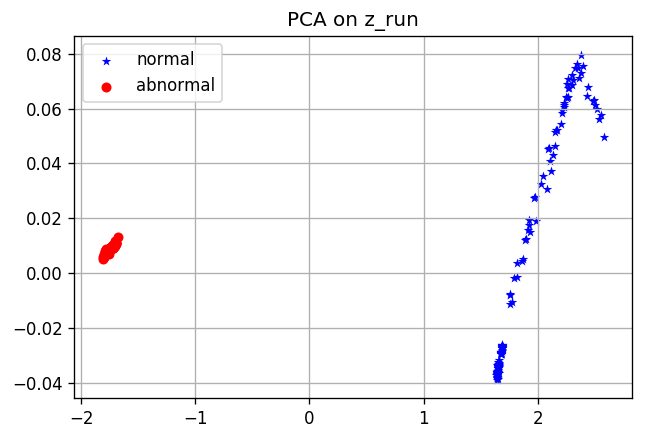

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.dpi'] = 120

# from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

z_run = z_mean.to(torch.device('cpu'))
z_run = z_run.detach().numpy()
PCA_model = TruncatedSVD(n_components=3).fit(z_run)
z_run_reduced = PCA_model.transform(z_run)
ground_truth = targets.to(torch.device('cpu'))
for k in range(batch_size):
    if ground_truth[k] ==1:
#z_mean, z_log_var, encoded, decoded = model(features, targets)
        plot1 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='b', marker='*', linewidths=0)
    else:
        plot2 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='r', marker='o', linewidths=0)        
plt.legend([plot1, plot2],('normal','abnormal'), loc='best')
plt.title('PCA on z_run')
plt.grid()
plt.show()

In [12]:
def data_to_real(inputdata):
    inputdata = inputdata * (inputdata.max()-inputdata.min()) + inputdata.min()
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

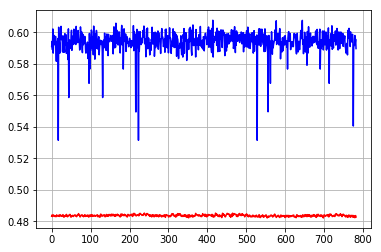

In [29]:
features1 = features.view(-1,28*28)
input_data = features1.to(torch.device('cpu'))
input_data = input_data.detach().numpy()
input_data = data_to_real(input_data)
input_data = input_data[:,:783]
de = model.decoder(z_mean, targets) # replace decoded by z_mean

decoded_data = de.to(torch.device('cpu'))
decoded_data = decoded_data.view(-1,28*28)
decoded_data = decoded_data.detach().numpy()
decoded_data = data_to_real(decoded_data)
decoded_data = decoded_data[:,:783]
idxx = np.random.randint(0,batch_size-1)
plt.plot(input_data[idxx],'b')
plt.plot(decoded_data[idxx],'r')
plt.grid()
plt.show()

### New random-conditional images

label
1.0


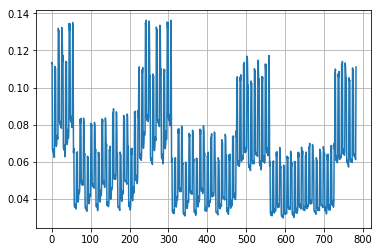

label
1.0


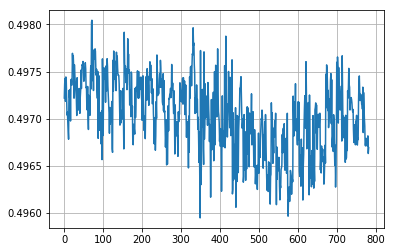

In [30]:
for i in range(2):
    labels = torch.tensor([i]*batch_size).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_te = model.decoder(rand_features, labels)
    new_te = new_te.view(-1,28*28)
    curr_te = new_te.detach().to(torch.device('cpu'))
    curr_te = curr_te.detach().numpy()
    curr_te = data_to_real(curr_te)
    curr_te = curr_te[:,:783]
    idxx = np.random.randint(0,batch_size-1)
    plt.plot(curr_te[idxx])
    print('label')
    print(label[idxx])
    plt.grid()
    plt.show()

In [8]:
%watermark -iv

numpy       1.15.4
torch       1.0.0

